# Projet 4 : Segmentez des clients d’un site e-commerce
##### Parcours: Ingénieur Machine Learning from OpenClassrooms
##### Ana Ibarra Velázquez

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Datasets

In [2]:
data_orders = pd.read_csv('olist_orders_dataset.csv', 
              usecols=['order_id','customer_id',
              'order_status','order_purchase_timestamp'])
data_customers = pd.read_csv('olist_customers_dataset.csv')
data_payments = pd.read_csv('olist_order_payments_dataset.csv')
data_reviews = pd.read_csv('olist_order_reviews_dataset.csv', 
               usecols=['order_id','review_score'])
data_product_translation = pd.read_csv('product_category_name_translation.csv')
data_order_items = pd.read_csv('olist_order_items_dataset.csv')
data_products_dataset = pd.read_csv('olist_products_dataset.csv', 
                        usecols=['product_id','product_category_name'])

In [3]:
# Merge data sets
data = pd.merge(data_customers,data_orders, on='customer_id', how='outer')
data = pd.merge(data,data_payments, on='order_id', how='outer')
data = pd.merge(data,data_reviews, on='order_id', how='outer')
data = pd.merge(data,data_order_items, on='order_id', how='outer')
data = pd.merge(data,data_products_dataset, on='product_id', how='outer')
data = pd.merge(data,data_product_translation, on='product_category_name', 
                how='outer')
data.drop(['payment_sequential', 'seller_id', 'shipping_limit_date',
           'product_category_name'], axis=1, inplace=True)
print(data.shape)
data.head(5)

(119151, 17)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,payment_type,payment_installments,payment_value,review_score,order_item_id,product_id,price,freight_value,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,credit_card,2.0,146.87,4,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,credit_card,1.0,275.79,1,1.0,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,office_furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,credit_card,1.0,275.79,1,2.0,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,office_furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,credit_card,7.0,140.61,3,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99,15.62,office_furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,credit_card,10.0,137.58,4,1.0,a9516a079e37a9c9c36b9b78b10169e8,106.99,30.59,office_furniture


### Exploratory analysis and cleanning

In [4]:
# Drop duplicates
data = data.drop_duplicates()
data.shape

(118025, 17)

In [5]:
status = data.groupby('order_status')['customer_unique_id'].nunique()
status = status.sort_values(ascending=False)
status

order_status
delivered      93358
shipped         1100
canceled         616
unavailable      604
invoiced         314
processing       301
created            5
approved           2
Name: customer_unique_id, dtype: int64

In [6]:
# There is not a client who cancels frequently
data['customer_unique_id'][data['order_status'] == 'canceled'].unique().size

616

In [7]:
# Drop incomplete data
data.dropna(inplace=True)
print(data.shape)
data.isna().any().any()

(115511, 17)


False

In [8]:
# Drop 6 orders canceled
data.drop(data[data.order_status == "canceled"].index, inplace=True)
data=data.reset_index(drop=True)

In [9]:
print("No. of cities: ",data.customer_city.unique().size)
print("No. of states: ",data.customer_state.unique().size)
print("No. of product categories: ",data.product_category_name_english.unique().size)
print("No. of order status: ",data.order_status.unique().size)
print("No. of customers: ",data.customer_id.unique().size)
print("No. of customers_unique: ",data.customer_unique_id.unique().size)
print("No. of customer_zip_code_prefix: ",data.customer_zip_code_prefix.unique().size)

No. of cities:  4094
No. of states:  27
No. of product categories:  71
No. of order status:  6
No. of customers:  96810
No. of customers_unique:  93670
No. of customer_zip_code_prefix:  14915


In [10]:
data.describe()

,customer_zip_code_prefix,payment_installments,payment_value,review_score,order_item_id,price,freight_value
count,114962.000000,114962.000000,114962.000000,114962.000000,114962.000000,114962.000000,114962.000000
mean,35102.394122,2.957108,173.335530,4.028148,1.196282,120.539018,20.063459
std,29818.654185,2.785615,266.868769,1.388650,0.699695,182.902695,15.840125
min,1003.000000,0.000000,0.000000,1.000000,1.000000,0.850000,0.000000
25%,11355.000000,1.000000,61.690000,4.000000,1.000000,39.900000,13.080000
50%,24343.000000,2.000000,108.770000,5.000000,1.000000,74.900000,16.320000
75%,58838.750000,4.000000,190.330000,5.000000,1.000000,134.900000,21.220000
max,99980.000000,24.000000,13664.080000,5.000000,21.000000,6735.000000,409.680000


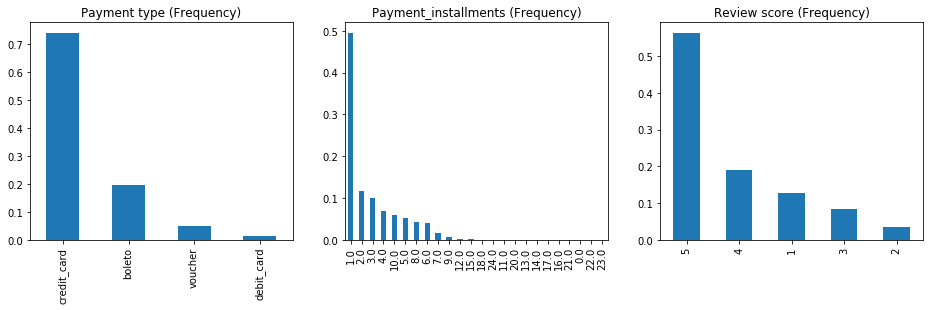

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) 
data['payment_type'].value_counts(normalize=True).plot(kind='bar',ax=axes[0],
                     title= "Payment type (Frequency)")
data['payment_installments'].value_counts(normalize=True).plot(kind='bar',
                        ax=axes[1],title= "Payment_installments (Frequency)")
data['review_score'].value_counts(normalize=True).plot(kind='bar',ax=axes[2],
                     title= "Review score (Frequency)")
plt.show()

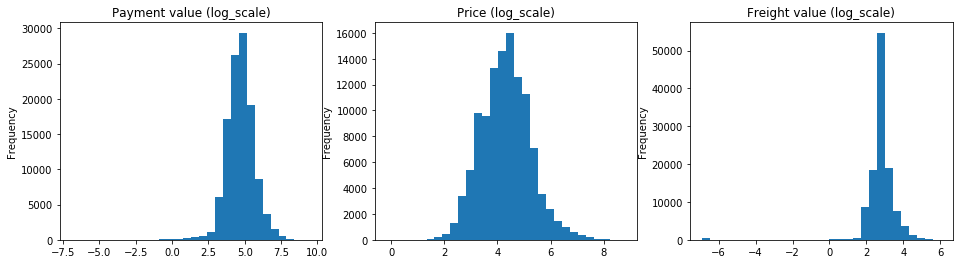

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) 
np.log(data['payment_value']+.001).plot.hist(bins=30, ax=axes[0],
       title= "Payment value (log_scale)")
np.log(data['price']+.001).plot.hist(bins=30, ax=axes[1],
      title= "Price (log_scale)")
np.log(data['freight_value']+.001).plot.hist(bins=30, ax=axes[2],
      title= "Freight value (log_scale)")
plt.show()

In [13]:
# Convert Datetime format
data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp)

In [14]:
# Creating new features
data['Date_order'] = data['order_purchase_timestamp'].dt.to_period('D'
                      ).astype('str')
data['Month_order'] = data['order_purchase_timestamp'].dt.to_period('M'
                      ).astype('str')
# All transactions are found between september 2016 and september 2018
data.Date_order.agg(['min', 'max'])

min    2016-09-04
max    2018-09-03
Name: Date_order, dtype: object

In [15]:
# A "customer_unique_id" can have more than one order
print("Customer unique id: ",len(data.customer_unique_id.unique()),
      "< Customer id: ", len(data.customer_id.unique()))

Customer unique id:  93670 < Customer id:  96810


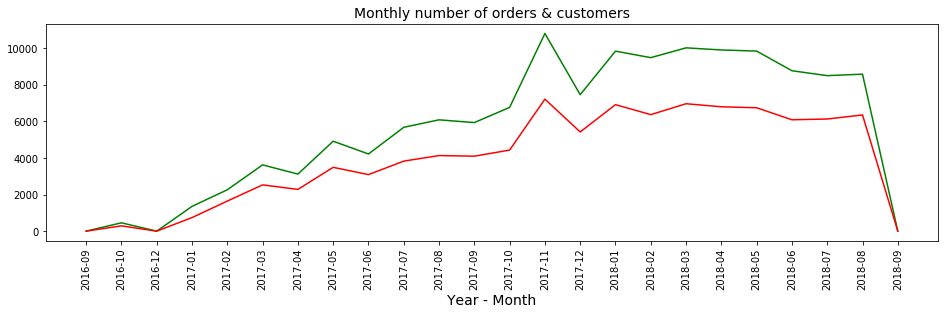

In [16]:
# Distribution of number of orders, customers and revenue per month
orders_per_month = data['order_item_id'].groupby(data['Month_order']).sum()
revenue_per_month = data['payment_value'].groupby(data['Month_order']).sum()
customer_per_month = data.groupby('Month_order')['customer_unique_id'
                                                ].nunique()

fig=plt.figure(figsize=(16,4))
sns.lineplot(x=orders_per_month.index, y=orders_per_month.values, 
             color="Green")
sns.lineplot(x=customer_per_month.index, y=customer_per_month.values, 
             color="Red")
plt.title('Monthly number of orders & customers',fontsize=14)
plt.xlabel('Year - Month',fontsize=14)
plt.xticks(rotation=90)
plt.show()

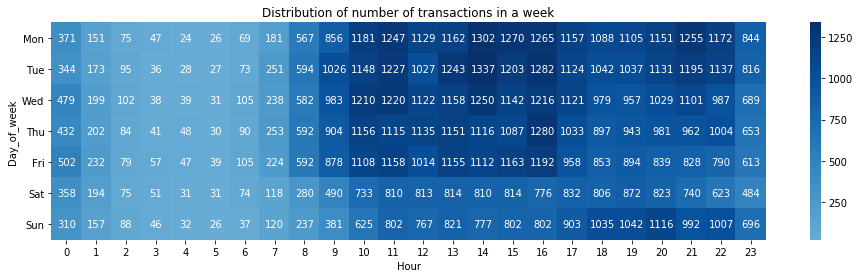

In [17]:
# Distribution of orders by week of the day and hour
pweekday = data['order_purchase_timestamp'].dt.weekday
data['Hour'] = data['order_purchase_timestamp'].dt.hour
purchase = pd.DataFrame({'Day_of_week': pweekday, 
                         'Hour': data['Hour'], 
                         'Price': data['payment_value']})
purchase['Day_of_week'] = purchase['Day_of_week'].map({0:'Mon',
                          1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
purchase_count = purchase.groupby(['Day_of_week', 'Hour'
                                  ]).count()['Price'].unstack()
# Heatmap
plt.figure(figsize=(16,4))
heat_map = sns.heatmap(purchase_count.reindex(
           index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']), 
           cmap="Blues", annot=True, fmt="d",center=0)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
bottom,top = heat_map.get_ylim()
heat_map.set_ylim(bottom+0.5,top-0.5)
heat_map.set_title("Distribution of number of transactions in a week")
plt.show()

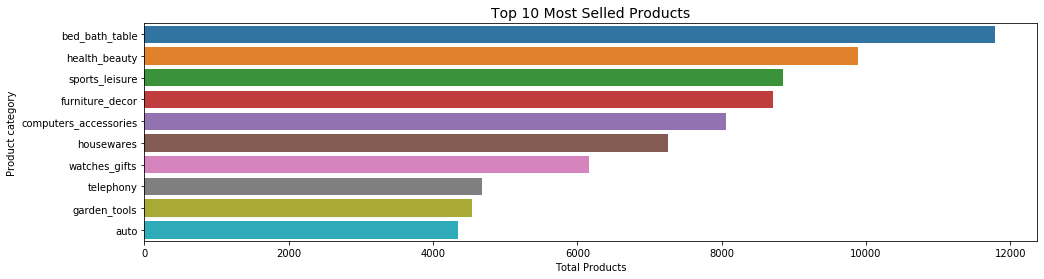

In [22]:
# Top 10 in products categories
order_category = data.groupby('product_category_name_english').size(\
                 ).reset_index(name='total_orders')
order_category_top10 = order_category.sort_values(by='total_orders', 
                 ascending=False).head(10)

plt.figure(figsize=(16,4))
sns.barplot(x=order_category_top10['total_orders'], 
            y=order_category_top10['product_category_name_english'])
plt.title('Top 10 Most Selled Products',fontsize=14)
plt.xlabel('Total Products')
plt.ylabel('Product category')
plt.show()

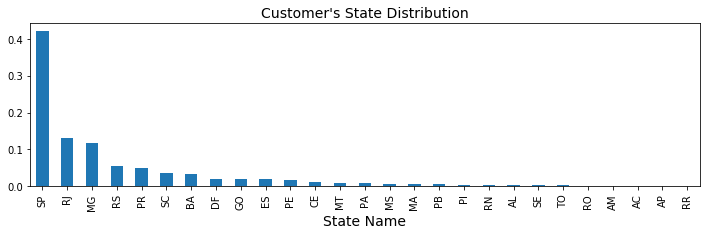

In [19]:
plt.figure(figsize=(12,3))
data['customer_state'].value_counts(normalize=True).plot(kind='bar',
                       title= "Customer's State Distribution")
#plt.yscale('log')
plt.xlabel("State Name", fontsize=14)
plt.title("Customer's State Distribution", fontsize=14)
plt.show()

In [20]:
data = data[['customer_id','customer_unique_id','customer_state',
        'order_purchase_timestamp','product_category_name_english',
        'payment_value','Hour','Date_order','Month_order']]

In [21]:
# Enregistrement au format CSV
data.info()
data.to_csv('Segmentation-clients-2ML.csv', index=False, header=True, sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114962 entries, 0 to 114961
Data columns (total 9 columns):
customer_id                      114962 non-null object
customer_unique_id               114962 non-null object
customer_state                   114962 non-null object
order_purchase_timestamp         114962 non-null datetime64[ns]
product_category_name_english    114962 non-null object
payment_value                    114962 non-null float64
Hour                             114962 non-null int64
Date_order                       114962 non-null object
Month_order                      114962 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 7.9+ MB
